In [12]:
def  Run_GeoShapesTests(NumEpochs=300):
    %matplotlib notebook
    import keras as keras
    from keras.models import Sequential
    from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D
    from keras.losses import binary_crossentropy, categorical_crossentropy
    from keras.metrics import categorical_accuracy
    from keras import regularizers,optimizers
    from keras.regularizers import l2
    import numpy as np
    import scipy.io
    import matplotlib.pyplot as plt
    import gzip
    from keras.layers.core import Lambda
    from scipy.integrate import trapz

    from keras.layers.core import Lambda
    from keras import backend as K    
    
    def mini_batches(InputSample,BatchSize):
        Index = np.array(range(InputSample.shape[0]),dtype=int)
        NumBatches = np.int(InputSample.shape[0]/BatchSize)
        Removed = np.array([],dtype=int)

        BatchInd =[]
        for BatchLoop in range(NumBatches):
            RemainIndex = np.delete(Index,Removed)
            SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
            Removed = np.append(Removed,SampleInd,axis=0)

            BatchInd.append(SampleInd)
        RemainIndex = np.delete(Index,Removed)
        BatchInd.append(RemainIndex)

        return BatchInd,NumBatches

    def Get_Feats_and_Targets(filename):
        import numpy as np

        def line_to_Feats(line):
            line = line.split(' ')
            Feats = np.asarray(line[0:1024])
            Target = np.zeros([3])
            Target[int(line[1024])] = 1
            return Feats,Target

        f = open(filename, 'r')
        lines = f.readlines()
        Features = []
        Targets = []
        for i in range(len(lines)-1):
            line = lines[i+1]
            Feats,Tgts = line_to_Feats(line)
            Features.append(Feats)
            Targets.append(Tgts)

        return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')

    [TrainInputs_Easy,TrainTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.10000.train.amat')
#     [ValInputs_Easy,ValTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.5000.valid.amat')

    [TrainInputs,TrainTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.10000.train.amat')
    [ValInputs,ValTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.valid.amat')
    
    FullTrainInputs = np.append(TrainInputs,TrainInputs_Easy,axis=0)
    FullTrainTargets = np.append(TrainTargets,TrainTargets_Easy,axis=0)
    
    print(TrainInputs.shape)

    data_dim = TrainInputs.shape[-1]
    NumSamples = TrainInputs.shape[0]
    NumSamplesFull = FullTrainInputs.shape[0]
    NumSamplesEasy = TrainInputs_Easy.shape[0]
    Num_Targets = TrainTargets.shape[-1]

    index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

    reg_coeff = 0

    def Gen_Model(reg_coeff):
        model = Sequential()
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dense(300,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
        model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
        optim = optimizers.adam(lr=0.0001)
        model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])

        return model

    UniHard_model = Gen_Model(reg_coeff) 
    UniEasy_model = Gen_Model(reg_coeff)
    Cur_model = Gen_Model(reg_coeff)
    Uni_model = Gen_Model(reg_coeff)
    Uni_model_full = Gen_Model(reg_coeff)
    
    UniHard_model.set_weights(Uni_model.get_weights())
    UniEasy_model.set_weights(Uni_model.get_weights())
    Cur_model.set_weights(Uni_model.get_weights())
    Uni_model_full.set_weights(Uni_model.get_weights())

    def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
        Output = model.predict(samples)
        Output -= 1/float(Num_Targets)
        Dist_to_Threshold = np.sum(np.abs(Output),1)
        Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
        Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        Target_Ratio = Target_Ratio
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
                Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        return Sampling_Prob
    
    
    def Exp_ModelChange(Model,Inputs,Num_Targets):
        ExpChange = np.zeros(Inputs.shape[0])
        for TargetLoop in range(Num_Targets):
            thisTarget = np.zeros([Inputs.shape[0],Num_Targets])
            thisTarget[:,TargetLoop] = 1
            Model_Output = Model.predict(Inputs)
            ClassProb = Model_Output[:,TargetLoop]
            Loss = np.mean(Model_Output - Model_Output*thisTarget + np.log(1+np.exp(-Model_Output)),1)
            ExpChange += Loss*ClassProb
        return ExpChange

    def acquisition_function_exp_model_change(model,samples,Num_Targets,temperature = 1,Target_Ratio = 5):
        ExpectedChange = Exp_ModelChange(model,samples,Num_Targets)
        ExpChange = np.exp(ExpectedChange/temperature)
        Sampling_Prob = ExpChange/np.sum(ExpChange).astype(float)
        Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        if Max_Prob_Ratio < Target_Ratio:
            while Max_Prob_Ratio <Target_Ratio:
                temperature = temperature*0.99
                ExpChange = np.exp(ExpectedChange/temperature)
                Sampling_Prob = ExpChange/np.sum(ExpChange).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        else:
            while Max_Prob_Ratio > Target_Ratio:
                temperature = temperature*1.01
                ExpChange = np.exp(ExpectedChange/temperature)
                Sampling_Prob = ExpChange/np.sum(ExpChange).astype(float)
                Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
        return Sampling_Prob

    count = 0 
    Num_Epochs = NumEpochs
    Num_BurnIn = 5
    Switch_Epoch = 128
    Batch_Size = 32

    Val_Error = np.zeros([Num_Epochs,5])
    Val_Acc = np.zeros([Num_Epochs,5])

    def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1):
        while True: 
            index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
            Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
            Batch_Inputs = Inputs[Batch,:]
            Batch_Targets = Targets[Batch,:]
            if Weighting_Flag == 1:
                FullWeights = Sampling_Probability**-1
                FullWeights = FullWeights/np.mean(FullWeights)
            elif Weighting_Flag == -1:
                FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
            else:
                FullWeights = np.ones(Inputs.shape[0])

            Weights = FullWeights[Batch]
            yield (Batch_Inputs,Batch_Targets,Weights)
            
    fig = plt.figure(figsize = [4,4])
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    fig2 = plt.figure(figsize = [4,4])
    ax2 = fig2.add_subplot(111)
    plt.ion()
    fig2.show()
    fig2.canvas.draw()
    
    fig3 = plt.figure(figsize = [4,4])
    ax3 = fig3.add_subplot(111)
    plt.ion()
    fig3.show()
    fig3.canvas.draw()
    
    fig4 = plt.figure(figsize = [4,4])
    ax4 = fig4.add_subplot(111)
    plt.ion()
    fig4.show()
    fig4.canvas.draw()


    for EpochLoop in  range(Num_Epochs):
        if count < Num_BurnIn:

            Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/np.float(NumSamples)*np.ones(NumSamples)),
                                steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
            
            Uni_model_full.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,1/np.float(NumSamplesFull)*np.ones(NumSamplesFull)),
                                steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=0)

            if count < Switch_Epoch:
                Cur_model.fit_generator(Biased_Batch(TrainInputs_Easy,TrainTargets_Easy,Batch_Size,1/np.float(NumSamplesEasy)*np.ones(NumSamplesEasy)),
                                steps_per_epoch=np.int(NumSamplesEasy/Batch_Size),verbose=0)
            else:
                Cur_model.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,1/np.float(NumSamplesFull)*np.ones(NumSamplesFull)),
                                steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=0)
            
            UniHard_model.set_weights(Uni_model_full.get_weights())
            UniEasy_model.set_weights(Uni_model_full.get_weights())
            
            Error = UniHard_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,0] = Error[0]
            Val_Acc[count,0] = Error[1]

            Error = UniEasy_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,1] = Error[0]
            Val_Acc[count,1] = Error[1]

            Error = Uni_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,2] = Error[0]
            Val_Acc[count,2] = Error[1]

            Error = Cur_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,3] = Error[0]
            Val_Acc[count,3] = Error[1]
            
            Error = Uni_model_full.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,4] = Error[0]
            Val_Acc[count,4] = Error[1]


        else:
            
            UniHard_Sampling_Probability = acquisition_function_exp_model_change(UniHard_model,FullTrainInputs,Num_Targets,1)
            UniEasy_Sampling_Probability = 1/acquisition_function_exp_model_change(UniEasy_model,FullTrainInputs,Num_Targets,1)
            UniEasy_Sampling_Probability /= UniEasy_Sampling_Probability.sum().astype(float)
            
            MaxProbInd = UniHard_Sampling_Probability.argmax()
            MinProbInd = UniHard_Sampling_Probability.argmin()

            ax3.clear()
            ax3.imshow(np.transpose(np.reshape(FullTrainInputs[MaxProbInd,:],[32,32])))
            fig3.canvas.draw()


            ax4.clear()
            ax4.imshow(np.transpose(np.reshape(FullTrainInputs[MinProbInd,:],[32,32])))
            fig4.canvas.draw()
    
            
            print(UniEasy_Sampling_Probability.max()/UniEasy_Sampling_Probability.min())

            UniHard_model.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,UniHard_Sampling_Probability,1),
                                     steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=0)

            UniEasy_model.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,UniEasy_Sampling_Probability,1),
                                     steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=0)

            Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/(NumSamples*np.ones(NumSamples))),
                                    steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
            
            Uni_model_full.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,1/(NumSamplesFull*np.ones(NumSamplesFull))),
                                    steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=0)

            if count < Switch_Epoch:
                Cur_model.fit_generator(Biased_Batch(TrainInputs_Easy,TrainTargets_Easy,Batch_Size,1/np.float(NumSamplesEasy)*np.ones(NumSamplesEasy)),
                                steps_per_epoch=np.int(NumSamplesEasy/Batch_Size),verbose=0)
            else:
                Cur_model.fit_generator(Biased_Batch(FullTrainInputs,FullTrainTargets,Batch_Size,1/np.float(NumSamplesFull)*np.ones(NumSamplesFull)),
                                steps_per_epoch=np.int(NumSamplesFull/Batch_Size),verbose=0)
            
            Error = UniHard_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,0] = Error[0]
            Val_Acc[count,0] = Error[1]

            Error = UniEasy_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,1] = Error[0]
            Val_Acc[count,1] = Error[1]

            Error = Uni_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,2] = Error[0]
            Val_Acc[count,2] = Error[1]

            Error = Cur_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,3] = Error[0]
            Val_Acc[count,3] = Error[1]
            
            Error = Uni_model_full.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,4] = Error[0]
            Val_Acc[count,4] = Error[1]
            
        print(count)

        count += 1
        ax.clear()
        ax.plot(Val_Error[0:count,0],label='IS-Hard')
        ax.plot(Val_Error[0:count,1],label='IS-Easy')
        ax.plot(Val_Error[0:count,2],label='Uniform')
        ax.plot(Val_Error[0:count,4],label='Uniform - Full')
        ax.plot(Val_Error[0:count,3],label='Curriculum 128')
        ax.legend(loc='best')
        fig.canvas.draw()
        
        ax2.clear()
        ax2.plot(Val_Acc[0:count,0],label='IS-Hard')
        ax2.plot(Val_Acc[0:count,1],label='IS-Easy')
        ax2.plot(Val_Acc[0:count,2],label='Uniform')
        ax2.plot(Val_Acc[0:count,4],label='Uniform - Full')
        ax2.plot(Val_Acc[0:count,3],label='Curriculum 128')
        fig2.canvas.draw()


    [TestInputs,TestTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.test.amat')

    TestError = np.zeros([5,2])
    TestError[0,:] = UniHard_model.test_on_batch(TestInputs,TestTargets)
    TestError[1,:] = UniEasy_model.test_on_batch(TestInputs,TestTargets)
    TestError[2,:] = Uni_model.test_on_batch(TestInputs,TestTargets)
    TestError[3,:] = Cur_model.test_on_batch(TestInputs,TestTargets)
    TestError[4,:] = Uni_model_full.test_on_batch(TestInputs,TestTargets)
    
    return Val_Error,Val_Acc,TestError

Test Number:
11
(10000, 1024)


<IPython.core.display.Javascript object>


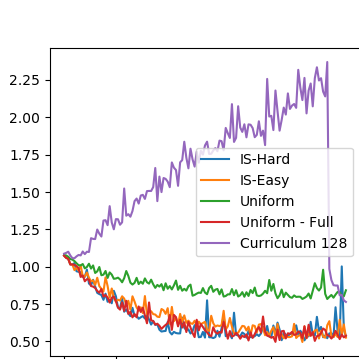

<IPython.core.display.Javascript object>


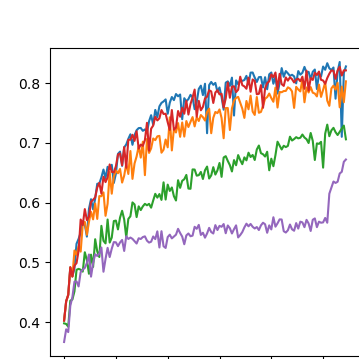

<IPython.core.display.Javascript object>


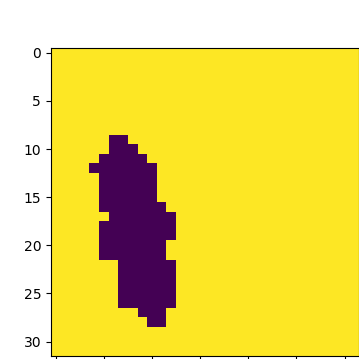

<IPython.core.display.Javascript object>


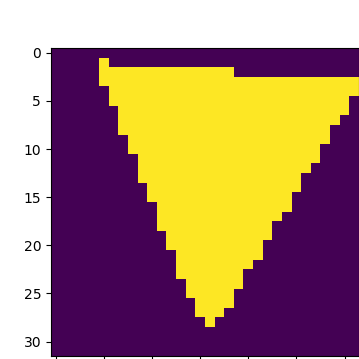

0
1
2
3
4
5.024724464973495
5
5.017599128951219
6
5.04041116812118
7
5.072736521087993
8
5.024510257047882
9
5.00610867057464
10
5.062552474937778
11
5.028674803690446
12
5.028919383719633
13
5.064245352629448
14
5.0444909291134525
15
5.032007660971792
16
5.045498419366887
17
5.075818115421235
18
5.071956478169576
19
5.039220149806831
20
5.0525046946148136
21
5.012297019332796
22
5.008692780486038
23
5.023369766932153
24
5.025998871705233
25
5.0231751991227815
26
5.026805065633458
27
5.021008091602128
28
5.017563149057119
29
5.030350775029143
30
5.025275683166976
31
5.027070663246212
32
5.022324351659624
33
5.028040235394679
34
5.036314672167808
35
5.035308065536191
36
5.0369739259148005
37
5.0334585383617725
38
5.034184496849813
39
5.036796833966329
40
5.037123056813413
41
5.036341680763898
42
5.038541521372252
43
5.039522150602299
44
5.0400389513657595
45
5.038440469122079
46
5.040259367701553
47
5.040163072155293
48
5.038793657940322
49
5.03869302605074
50
5.040194472850545
51
5.038

In [ ]:
import numpy as np
import datetime

from IPython.display import clear_output

NumTests = 1000
NumEpochs = 256
Val_Error_Record = np.zeros([NumEpochs,5,NumTests])
Val_Acc_Record = np.zeros([NumEpochs,5,NumTests])
Test_Perf_Record = np.zeros([5,2,NumTests])

for TestLoop in range(NumTests):
    clear_output()
    print('Test Number:')
    print(TestLoop)
    Val_Error_Record[:,:,TestLoop],Val_Acc_Record[:,:,TestLoop],Test_Perf_Record[:,:,TestLoop] = Run_GeoShapesTests(NumEpochs)
    
    DateString = str(datetime.datetime.date(datetime.datetime.now()))
    
    np.save("GeoShapes_Curriculum_FullUniform_TestPerf_ExpChange",Test_Perf_Record)
    np.save("GeoShapes_Curriculum_FullUniform_ValError_ExpChange",Val_Error_Record)
    np.save("GeoShapes_Curriculum_FullUniform_ValAcc_ExpChange",Val_Acc_Record)

In [ ]:
a,b,c = Run_GeoShapesTests(NumEpochs)

In [6]:
import datetime

In [16]:
thisdate =  str(datetime.datetime.date(datetime.datetime.now()))

In [17]:
thisdata

'2018-06-11'

In [17]:
from keras.activations import relu
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.regularizers import l2
data_dim = 10
reg_coeff = 0.01

In [18]:
model = Sequential()
model.add(Dense(100,input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
model.add(Activation(relu))

In [5]:
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz

from keras.layers.core import Lambda
from keras import backend as K   

In [4]:
NumEpochs=300
%matplotlib notebook
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz

from keras.layers.core import Lambda
from keras import backend as K    

def Get_Feats_and_Targets(filename):
    import numpy as np

    def line_to_Feats(line):
        line = line.split(' ')
        Feats = np.asarray(line[0:1024])
        Target = np.zeros([3])
        Target[int(line[1024])] = 1
        return Feats,Target

    f = open(filename, 'r')
    lines = f.readlines()
    Features = []
    Targets = []
    for i in range(len(lines)-1):
        line = lines[i+1]
        Feats,Tgts = line_to_Feats(line)
        Features.append(Feats)
        Targets.append(Tgts)

    return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')

[TrainInputs_Easy,TrainTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.10000.train.amat')
#     [ValInputs_Easy,ValTargets_Easy] = Get_Feats_and_Targets('shapeset1_1cspo_2_3.5000.valid.amat')

[TrainInputs,TrainTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.10000.train.amat')
[ValInputs,ValTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.valid.amat')

data_dim = TrainInputs.shape[-1]
NumSamples = TrainInputs.shape[0]
Num_Targets = TrainTargets.shape[-1]

index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

reg_coeff = 0.001

def Gen_Model(reg_coeff):
    model = Sequential()
    model.add(Dense(100,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(100,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(100,activation='tanh',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.adagrad(lr=0.001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])

    return model

#     ISHard_model = Gen_Model(reg_coeff)

#     ISEasy_model = Gen_Model(reg_coeff)

UniHard_model = Gen_Model(reg_coeff)

UniEasy_model = Gen_Model(reg_coeff)

#     Easy_model = Gen_Model(reg_coeff)

#     Hard_model =Gen_Model(reg_coeff)

Cur_model = Gen_Model(reg_coeff)

Uni_model = Gen_Model(reg_coeff)



def ablate_network(model,ablation_perc):
weights = model.get_weights()
save_weights = weights.copy()
NumLayers = len(weights)
total_numweights  = 0 
for i in range(NumLayers):
    layer = weights[i]
    total_numweights += len(layer.flatten())
num_ablations = np.int(ablation_perc*total_numweights)
weights = ablate_weights(weights,num_ablations)
model.set_weights(weights)

return(model,save_weights)


def ablation_curve(model,num_tests,max_perc,inputs,targets):
Perc_Space = np.linspace(0,max_perc,num_tests)
Performance = np.zeros(num_tests)
for i in range(num_tests):
    model,save_weights = ablate_network(model,Perc_Space[i])
    Perf = model.test_on_batch(inputs,targets)
    Performance[i] = Perf[1]
    model.set_weights(save_weights)

    AUC = trapz(Performance,Perc_Space)

return AUC,Performance


def ablate_weights(weights,num_ablations):
NumLayers = len(weights)
LayerShape = []
LayerShape = []
LayerNodes = [0]
FlattenedNodes = np.empty([0])
for i in range(NumLayers):
    LayerShape.append(weights[i].shape)
    LayerNodes.append(len(weights[i].flatten()))
    FlattenedNodes = np.append(FlattenedNodes,weights[i].flatten())
    Index = np.linspace(0,len(FlattenedNodes)-1,num=len(FlattenedNodes),dtype = int)
RandChoice = np.random.choice(Index,size = num_ablations,replace=False)
FlattenedNodes[RandChoice] = 0
FirstInd = 0
for i in range(NumLayers):
    FirstInd += LayerNodes[i]
    SecondInd = FirstInd + LayerNodes[i+1]
    Sample = FlattenedNodes[FirstInd:SecondInd]
    Sample = Sample.reshape(LayerShape[i])
    weights[i] = Sample

return weights


def acquisition_function_ablation(model,Inputs,Targets,Cluster_Size):
BatchInd,NumBatches = mini_batches(Inputs,Cluster_Size)
AUC_Record = np.zeros([Inputs.shape[0]])
count= 0
for Batch in BatchInd:
    if Batch.shape[0] != 0:
        BatchInputs = Inputs[Batch,:]
        BatchTargets = Targets[Batch,:]
        SaveWeights = model.get_weights()
        Hard_model.fit(BatchInputs,BatchTargets,batch_size=64,verbose=0)
        AUC,_ = ablation_curve(model,30,1,Inputs,Targets)
        AUC_Record[Batch] = AUC.copy()
        Hard_model.set_weights(SaveWeights)
        count +=1

Sampling_Prob = AUC_Record/AUC_Record.sum()
return Sampling_Prob

def acquisition_function_dist_to_threshold(model,samples,Num_Targets,Smoothing_Const=0,Rescale=0):
    Output = model.predict(samples)
    Output -= 1/Num_Targets
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold) + Smoothing_Const
    Exp_Dist_to_Threshold *= 1
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
    if Rescale == 1:
        Median_Prob = np.median(Sampling_Prob)
        Min_Prob = np.min(Sampling_Prob)
        Sampling_Prob[Sampling_Prob > Median_Prob] += Min_Prob/2
        Sampling_Prob[Sampling_Prob < Median_Prob] -= Min_Prob/2
    return Sampling_Prob

def Exp_ModelChange(Model,Inputs,Num_Targets):
    ExpChange = np.zeros(Inputs.shape[0])
    for TargetLoop in range(Num_Targets):
        thisTarget = np.zeros([Inputs.shape[0],Num_Targets])
        thisTarget[:,TargetLoop] = 1
        Model_Output = Model.predict(Inputs)
        ClassProb = Model_Output[:,TargetLoop]
        Loss = np.mean(Model_Output - Model_Output*thisTarget + np.log(1+np.exp(-Model_Output)),1)
        ExpChange += Loss*ClassProb
    return ExpChange

def acquisition_function_exp_model_change(model,samples,Num_Targets,Smoothing_Const=0,Rescale=0):
    ExpChange = Exp_ModelChange(model,samples,Num_Targets) + Smoothing_Const
    Sampling_Prob = ExpChange/np.sum(ExpChange)
    if Rescale == 1:
        Median_Prob = np.median(Sampling_Prob)
        Min_Prob = np.min(Sampling_Prob)
        Sampling_Prob[Sampling_Prob > Median_Prob] += Min_Prob/2
        Sampling_Prob[Sampling_Prob < Median_Prob] -= Min_Prob/2
    return Sampling_Prob

count = 0 
Num_Epochs = NumEpochs
Num_BurnIn = 5
Switch_Epoch = 128
Batch_Size = 32

Smoothing_Constant = 0

Val_Error = np.zeros([Num_Epochs,4])
Val_Acc = np.zeros([Num_Epochs,4])

def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1):
    while True: 
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])

        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)


for EpochLoop in  range(Num_Epochs):
    if count < Num_BurnIn:
#             ISHard_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
#             Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
#             Val_Error[count,0] = Error[0]
#             Val_Acc[count,0] = Error[1]

#             ISEasy_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
#             Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
#             Val_Error[count,1] = Error[0]
#             Val_Acc[count,1] = Error[1]

#             Hard_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
#             Error = Hard_model.test_on_batch(ValInputs,ValTargets)
#             Val_Error[count,2] = Error[0]
#             Val_Acc[count,2] = Error[1]

#             Easy_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
#             Error = Easy_model.test_on_batch(ValInputs,ValTargets)
#             Val_Error[count,3] = Error[0]
#             Val_Acc[count,3] = Error[1]

        UniHard_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = UniHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]

        UniEasy_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = UniEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]

        Uni_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]

        if count < Switch_Epoch:
            Cur_model.fit(TrainInputs_Easy,TrainTargets_Easy,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
            Error = Cur_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,3] = Error[0]
            Val_Acc[count,3] = Error[1]
        else:
            Cur_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
            Error = Cur_model.test_on_batch(ValInputs,ValTargets)
            Val_Error[count,3] = Error[0]
            Val_Acc[count,3] = Error[1]


    else:
#             ISHard_Sampling_Probability = acquisition_function_dist_to_threshold(ISHard_model,TrainInputs,Num_Targets,0,0)
#             ISEasy_SamplingProbability = 1/acquisition_function_dist_to_threshold(ISEasy_model,TrainInputs,Num_Targets,0,0)
#             ISEasy_SamplingProbability/= ISEasy_SamplingProbability.sum().astype(float)

#             Hard_Sampling_Probability = acquisition_function_dist_to_threshold(Hard_model,TrainInputs,Num_Targets,0,0)
#             Easy_SamplingProbability = 1/acquisition_function_dist_to_threshold(Easy_model,TrainInputs,Num_Targets,0,0)
#             Easy_SamplingProbability/= Easy_SamplingProbability.sum().astype(float)

        UniHard_Sampling_Probability = acquisition_function_ablation(UniHard_model,TrainInputs,Num_Targets,32)
        UniEasy_Sampling_Probability = 1/acquisition_function_ablation(UniEasy_model,TrainInputs,Num_Targets,32)
        UniEasy_Sampling_Probability /= UniEasy_Sampling_Probability.sum().astype(float)

#             ISHard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,ISHard_Sampling_Probability,1),
#                                      steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

#             ISEasy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,ISEasy_SamplingProbability,1),
#                                      steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

#             Hard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Hard_Sampling_Probability,-1),
#                                      steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

#             Easy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Easy_SamplingProbability,-1),
#                                      steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

        UniHard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,UniHard_Sampling_Probability,0),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

        UniEasy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,UniEasy_Sampling_Probability,0),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

        Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/(NumSamples*np.ones(NumSamples))),
                                steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

        if count < Switch_Epoch:
            Cur_model.fit(TrainInputs_Easy,TrainTargets_Easy,batch_size = Batch_Size,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        else:
            Cur_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)


#             Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
#             Val_Error[count,0] = Error[0]
#             Val_Acc[count,0] = Error[1]

#             Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
#             Val_Error[count,1] = Error[0]
#             Val_Acc[count,1] = Error[1]

#             Error = Hard_model.test_on_batch(ValInputs,ValTargets)
#             Val_Error[count,2] = Error[0]
#             Val_Acc[count,2] = Error[1]

#             Error = Easy_model.test_on_batch(ValInputs,ValTargets)
#             Val_Error[count,3] = Error[0]
#             Val_Acc[count,3] = Error[1]

        Error = UniHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]

        Error = UniEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]

        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]

        Error = Cur_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,3] = Error[0]
        Val_Acc[count,3] = Error[1]

    count += 1


[TestInputs,TestTargets] = Get_Feats_and_Targets('shapeset2_1cspo_2_3.5000.test.amat')

TestError = np.zeros([4,2])
#     TestError[0,:] = ISHard_model.test_on_batch(TestInputs,TestTargets)
#     TestError[1,:] = ISEasy_model.test_on_batch(TestInputs,TestTargets)
#     TestError[2,:] = Hard_model.test_on_batch(TestInputs,TestTargets)
#     TestError[3,:] = Easy_model.test_on_batch(TestInputs,TestTargets)
TestError[0,:] = UniHard_model.test_on_batch(TestInputs,TestTargets)
TestError[1,:] = UniEasy_model.test_on_batch(TestInputs,TestTargets)
TestError[2,:] = Uni_model.test_on_batch(TestInputs,TestTargets)
TestError[3,:] = Cur_model.test_on_batch(TestInputs,TestTargets)
    

IndentationError: expected an indented block (<ipython-input-4-1a63bc91cc64>, line 86)